In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from catboost import Pool, CatBoostClassifier, cv
pd.options.display.max_columns
pd.set_option('display.max_columns', None)

# Data Prep

In [2]:
X_train = pd.read_csv('https://raw.githubusercontent.com/mkleinbort/Kaggle-COMPAS/main/train/X_train.csv', index_col='id')
y_train = pd.read_csv('https://raw.githubusercontent.com/mkleinbort/Kaggle-COMPAS/main/train/y_train.csv', squeeze=True)
X_test = pd.read_csv ('https://raw.githubusercontent.com/mkleinbort/Kaggle-COMPAS/main/test/X_test.csv')
y_test = np.full(len(X_test), np.nan)

In [3]:
df = pd.concat([X_train, X_test])

df = df.drop(['v_screening_date'], axis=1) # duplicate of 'screening_date'
df = df.drop(['v_type_of_assessment'], axis=1) # duplicate of 'type_of_assessment'
df = df.drop(['type_of_assessment'], axis=1) # 0 variance

df['target'] = y_train.to_list() + list(y_test) # set target row-wise (ignoring indices)
# df['target'] = 0

In [4]:
# Engineer a new targets 
df['target_int'] = df['target'].replace({'No-Recidivism': 0, 'Non-Violent': 1, 'Violent': 2}) # so we can do regression
df['target_bool'] = df['target'].replace({'No-Recidivism': 0, 'Non-Violent': 1, 'Violent': 1}) # 0 - no-rec, 1 - rec
target_cols = ['target', 'target_int', 'target_bool']

In [5]:
# Engineer new date based features

"""
Custody: when someone is kept in prison until they go to court
Screening:  involves  using  a  brief  instrument  to  quickly  capture basic information 
    about a person’s risk to reoffend and is  used  to  determine  if  a  more  comprehensive  assessment
    is  warranted.  In  a  jail  setting,  everyone,  regardless  of  legal  status, should be screened 
    at booking.  Risk  screening  divides  the  jail  population  into  high-,  medium-,  and  low-risk 
    categories,  making  it  possible  to  direct  intervention  resources  first  to  the highest-risk individuals.



- c_arrest_date and c_offense_date are mutually exclusive and one of them is 99.8% likely to be filled
- c_arrest_date and c_are mutually exclusive
- start is number of days between c_jail_in and c_jail_out, maybe worth engineering total hours/minutes between
- screening_date is always filled
"""



days_cols = []

def days_between(d1, d2):
    try:
        try:
            d1 = datetime.strptime(d1, "%Y-%m-%d")
        except ValueError:
            d1 = datetime.strptime(d1, "%Y-%m-%d %H:%M:%S")
            
        try:
            d2 = datetime.strptime(d2, "%Y-%m-%d")
        except ValueError:
            d2 = datetime.strptime(d2, "%Y-%m-%d %H:%M:%S")
        return abs((d2 - d1).days)
    except TypeError as e:
        return None

# mutually exclusive and one of them is always filled
df['c_bad_date'] = df['c_arrest_date'].fillna(df['c_offense_date']).fillna(df['in_custody']).fillna(df['screening_date'])

# how many days in custody
df['custody_days'] = df.apply(lambda x: days_between(x.out_custody, x.in_custody), axis=1)

# how quickly after going into custody did the person get screened (might indicate something?)
df['in_custody_to_screening_days'] = df.apply(lambda x: days_between(x.in_custody, x.screening_date), axis=1)

# questionable col because it is age related... Also corr=1 with age
df['birth_to_bad_days'] = df.apply(lambda x: days_between(x.date_of_birth, x.c_bad_date), axis=1)

# How many days passed until recitivism occcured. Golden feature!
df['days_until_recitivism'] = df.apply(lambda x: days_between(x.c_jail_out, x.r_jail_in), axis=1)

date_cols = [ 
    'c_arrest_date', 
    'c_offense_date',
    'screening_date', 
    'in_custody', 
    'out_custody', 
    'date_of_birth',
    'c_jail_in',
    'c_jail_out',
    'r_jail_in',
    'r_jail_out',

    # engineered
    'c_bad_date'
]

duration_cols = [
    'days_b_screening_arrest',
    'custody_days',
    'in_custody_to_screening_days',
    'birth_to_bad_days',
    'days_until_recitivism',
]

df.head()

,name,first,last,sex,date_of_birth,age,age_group,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_offense_date,c_arrest_date,c_charge_degree,c_charge_desc,r_jail_in,r_jail_out,screening_date,in_custody,out_custody,start,id,target,target_int,target_bool,c_bad_date,custody_days,in_custody_to_screening_days,birth_to_bad_days,days_until_recitivism
2677,nicholas staggewise,nicholas,staggewise,Male,1994-02-28,22,Less than 25,Caucasian,0,0,0,2,-1.0,2013-09-23 09:01:58,2013-09-27 03:54:42,NaN,2013-09-23,F,arrest case no charge,NaN,NaN,2013-09-24,2013-09-23,2013-09-27,3,NaN,No-Recidivism,0.0,0.0,2013-09-23,4.0,1.0,7147,NaN
548,newton smith,newton,smith,Male,1995-01-28,21,Less than 25,African-American,0,1,0,1,-1.0,2013-06-16 12:36:42,2013-06-16 07:01:42,2013-06-15,NaN,F,Grand Theft in the 3rd Degree,NaN,NaN,2013-06-17,2013-06-16,2013-06-16,0,NaN,Violent,2.0,1.0,2013-06-15,0.0,1.0,6713,NaN
4483,terrance irvin,terrance,irvin,Male,1984-04-10,32,25 - 45,African-American,0,0,0,6,-1.0,2013-10-11 05:38:14,2013-10-15 07:11:17,2013-10-11,NaN,F,Grand Theft in the 3rd Degree,2013-12-21,2014-02-21,2013-10-12,2013-10-11,2013-10-15,3,NaN,Non-Violent,1.0,1.0,2013-10-11,4.0,1.0,10776,66.0
9476,jaimie peterson,jaimie,peterson,Female,1986-01-02,30,25 - 45,African-American,0,0,0,3,-1.0,2014-01-11 06:56:43,2014-01-12 02:17:00,2014-01-11,NaN,F,Felony Driving While Lic Suspd,NaN,NaN,2014-01-12,2014-01-11,2014-01-12,0,NaN,No-Recidivism,0.0,0.0,2014-01-11,1.0,1.0,10236,NaN
199,ritesh sukhlall,ritesh,sukhlall,Male,1987-05-12,28,25 - 45,Caucasian,0,0,0,2,NaN,NaN,NaN,NaN,2013-03-21,F,arrest case no charge,NaN,NaN,2013-08-29,NaN,NaN,0,NaN,No-Recidivism,0.0,0.0,2013-03-21,NaN,NaN,9445,NaN


In [6]:
# All prior counts
df['all_priors'] = df[[
    'juv_fel_count',
    'juv_misd_count', 
    'juv_other_count',
    'priors_count',
]].sum(axis=1)

In [7]:
# Has recidivism occured?
df['has_r_jail_in'] = df['r_jail_in'].notna()
df['has_r_jail_out'] = df['r_jail_out'].notna()

In [8]:
# fill missing values
df['c_charge_desc'] = df['c_charge_desc'].fillna('missing') 

In [9]:
df.head()

,name,first,last,sex,date_of_birth,age,age_group,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_offense_date,c_arrest_date,c_charge_degree,c_charge_desc,r_jail_in,r_jail_out,screening_date,in_custody,out_custody,start,id,target,target_int,target_bool,c_bad_date,custody_days,in_custody_to_screening_days,birth_to_bad_days,days_until_recitivism,all_priors,has_r_jail_in,has_r_jail_out
2677,nicholas staggewise,nicholas,staggewise,Male,1994-02-28,22,Less than 25,Caucasian,0,0,0,2,-1.0,2013-09-23 09:01:58,2013-09-27 03:54:42,NaN,2013-09-23,F,arrest case no charge,NaN,NaN,2013-09-24,2013-09-23,2013-09-27,3,NaN,No-Recidivism,0.0,0.0,2013-09-23,4.0,1.0,7147,NaN,2,False,False
548,newton smith,newton,smith,Male,1995-01-28,21,Less than 25,African-American,0,1,0,1,-1.0,2013-06-16 12:36:42,2013-06-16 07:01:42,2013-06-15,NaN,F,Grand Theft in the 3rd Degree,NaN,NaN,2013-06-17,2013-06-16,2013-06-16,0,NaN,Violent,2.0,1.0,2013-06-15,0.0,1.0,6713,NaN,2,False,False
4483,terrance irvin,terrance,irvin,Male,1984-04-10,32,25 - 45,African-American,0,0,0,6,-1.0,2013-10-11 05:38:14,2013-10-15 07:11:17,2013-10-11,NaN,F,Grand Theft in the 3rd Degree,2013-12-21,2014-02-21,2013-10-12,2013-10-11,2013-10-15,3,NaN,Non-Violent,1.0,1.0,2013-10-11,4.0,1.0,10776,66.0,6,True,True
9476,jaimie peterson,jaimie,peterson,Female,1986-01-02,30,25 - 45,African-American,0,0,0,3,-1.0,2014-01-11 06:56:43,2014-01-12 02:17:00,2014-01-11,NaN,F,Felony Driving While Lic Suspd,NaN,NaN,2014-01-12,2014-01-11,2014-01-12,0,NaN,No-Recidivism,0.0,0.0,2014-01-11,1.0,1.0,10236,NaN,3,False,False
199,ritesh sukhlall,ritesh,sukhlall,Male,1987-05-12,28,25 - 45,Caucasian,0,0,0,2,NaN,NaN,NaN,NaN,2013-03-21,F,arrest case no charge,NaN,NaN,2013-08-29,NaN,NaN,0,NaN,No-Recidivism,0.0,0.0,2013-03-21,NaN,NaN,9445,NaN,2,False,False


In [10]:
##########################################
### Select features to use in modeling ###
##########################################

cols = [
#     'name', useless
#     'first', useless
#     'last', useless
#     'sex', # 0 importance + potential bias
#     'date_of_birth', date
#     'age', # innapropriate bias
#     'age_group', # innapropriate bias
#     'race', # innapropriate bias
#     'juv_fel_count',
#     'juv_misd_count', 
#     'juv_other_count',
#     'priors_count', 
    'days_b_screening_arrest', # + AUC, - fairness
#     'c_jail_in', date
#     'c_jail_out',date
#     'c_offense_date', date
#     'c_arrest_date', date
#     'c_charge_degree',  # 0 importance
#     'c_charge_desc',
#     'r_jail_in', date
#     'r_jail_out', date
#     'screening_date', date
#     'in_custody', date
#     'out_custody', date
    'start', # + AUC, + fairness
#     'target', target
#     'target_int', target
#     'target_bool', target
#     'c_bad_date', date
    'custody_days', # + AOC, + fairness
    'in_custody_to_screening_days', # + AUC, + fairness
#     'birth_to_bad_days', # corr=1 with age
#     'has_r_jail_in', + AUC, - fairness
#     'has_r_jail_out', # corr=1 with r_jail_in
    'days_until_recitivism', # golden feature!
    'all_priors', # good
]

cat_cols = [
#     'sex',  # innapropriate bias
#     'age_group', # innapropriate bias
#     'race', # innapropriate bias
#     'c_charge_degree', # 0 importance
#     'c_charge_desc',
]

In [11]:
# Count missing values
df[cols].isna().sum()/len(df[cols])

days_b_screening_arrest         0.056504
start                           0.000000
custody_days                    0.044065
in_custody_to_screening_days    0.044065
days_until_recitivism           0.855577
all_priors                      0.000000
dtype: float64

<AxesSubplot:>

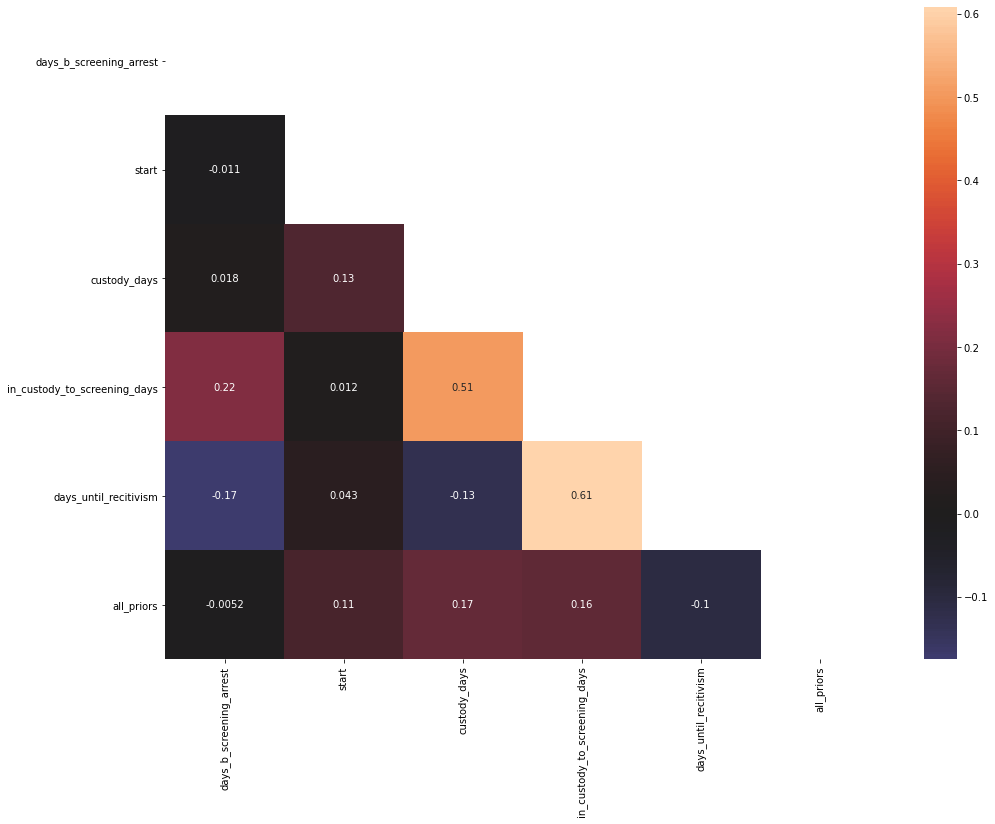

In [12]:
# Numeric correlations across numeric features
f, ax = plt.subplots(figsize=(16, 12))
corr = df[cols].corr()
mask = np.triu(corr)
sns.heatmap(corr.select_dtypes('number'), annot=True, center=0, mask=mask)

In [13]:
df[cols].head()

,days_b_screening_arrest,start,custody_days,in_custody_to_screening_days,days_until_recitivism,all_priors
2677,-1.0,3,4.0,1.0,NaN,2
548,-1.0,0,0.0,1.0,NaN,2
4483,-1.0,3,4.0,1.0,66.0,6
9476,-1.0,0,1.0,1.0,NaN,3
199,NaN,0,NaN,NaN,NaN,2


In [14]:
# df['race'] = df['race'].replace({'Native American': 'Other'})
# df['race'] = df['race'].replace({'Native American': 'Other', 'Asian': 'Other'})
df['race'] = df['race'].replace({'Native American': 'Other', 'Asian': 'Other', 'Hispanic': 'Other'})
df['race'].value_counts()

African-American    2266
Caucasian           1701
Other                776
Name: race, dtype: int64

In [15]:
races = df.race.unique()
sexes = df.sex.unique()
age_groups = df.age_group.unique()

df.shape

(3794, 35)

# Cross Validation

In [16]:
df[cols] = df[cols].fillna(0)

In [17]:
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score

def fairness_score(y_true, y_pred, sensitive_features):
    mf = MetricFrame(roc_auc_score, y_true, y_pred, sensitive_features=sensitive_features)
    return (1 - np.sqrt(np.std(mf.by_group)))

In [18]:
df_train = df[df.target.notna()]

df_test = df[df.target.isna()]

# Multi-class Classification
Non-recidivism / Non-Violent / Violent

In [19]:
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
import collections
from fairlearn.metrics import MetricFrame

TARGET_COL = 'target'

N_SPLITS = 5
N_REPEATS = 10

# Stratify based on intersections of race, age_group, sex and target.
strat_df = pd.DataFrame(df_train[TARGET_COL].astype('str') + df_train['race'] + df_train['sex'] + df_train['age_group'], columns=['name'])

# If cross section is too small for stratification to work (N < N_SPLITS) we mark it as an outlier
strat_df.loc[strat_df.groupby('name').name.transform('count').lt(N_SPLITS), 'name'] = 'Outliers'    

kf = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=42)

roc_aucs = []
rms = []
sms = []
ams = []

feature_importances = []
for split_idx, (train, test) in enumerate(kf.split(df_train[cols], strat_df['name'])): # Stratified on race
    df_train_cv = df.iloc[train].reset_index(drop=True)
    df_eval_cv = df.iloc[test].reset_index(drop=True)
    
    train_dataset = Pool(data=df_train_cv[cols],
                         label=df_train_cv[TARGET_COL],
                         cat_features=cat_cols)

    eval_dataset = Pool(data=df_eval_cv[cols],
                        label=df_eval_cv[TARGET_COL],
                        cat_features=cat_cols)
    
    y_eval = pd.get_dummies(df_eval_cv[TARGET_COL]).to_numpy()
    # Initialize CatBoostClassifier
    model = CatBoostClassifier(iterations=100,
                               learning_rate=1,
                               depth=3,
                               loss_function='MultiClass')
    # Fit model
    model.fit(train_dataset, verbose=False)
#     # Get predicted probabilities for each class
    preds_proba = model.predict_proba(eval_dataset)
    
    roc_auc = roc_auc_score(y_eval, preds_proba, multi_class="ovo")
    rm = MetricFrame(roc_auc_score, y_eval, preds_proba, sensitive_features=df_eval_cv['race'])
    sm = MetricFrame(roc_auc_score, y_eval, preds_proba, sensitive_features=df_eval_cv['sex'])
    am = MetricFrame(roc_auc_score, y_eval, preds_proba, sensitive_features=df_eval_cv['age_group'])
    
    roc_aucs.append(roc_auc)
    rms.append(rm)
    sms.append(sm)
    ams.append(am)
        
    roc_aucs.append(roc_auc)
    feature_importances.append(model.get_feature_importance())
    # avg_precs.append(avg_prec)
    race_fairness = 1 - np.sqrt(np.std(rm.by_group))
    sex_fairness = 1 - np.sqrt(np.std(sm.by_group))
    age_fairness = 1 - np.sqrt(np.std(am.by_group))
    print(f'Split {split_idx+1:2}: ROC-AUC: {roc_auc*100:.2f}%. '
          f'Fairness: R: {race_fairness*100:.2f}%, S: {sex_fairness*100:.2f}%, A: {age_fairness*100:.2f}%')

Split  1: ROC-AUC: 86.03%. Fairness: R: 88.57%, S: 75.44%, A: 73.60%
Split  2: ROC-AUC: 86.83%. Fairness: R: 83.84%, S: 79.62%, A: 81.08%
Split  3: ROC-AUC: 87.34%. Fairness: R: 76.24%, S: 94.99%, A: 87.83%
Split  4: ROC-AUC: 89.28%. Fairness: R: 79.04%, S: 92.23%, A: 80.14%
Split  5: ROC-AUC: 88.69%. Fairness: R: 88.25%, S: 82.94%, A: 79.06%
Split  6: ROC-AUC: 86.38%. Fairness: R: 83.54%, S: 85.73%, A: 88.91%
Split  7: ROC-AUC: 88.91%. Fairness: R: 81.14%, S: 81.51%, A: 83.32%
Split  8: ROC-AUC: 85.01%. Fairness: R: 82.58%, S: 83.78%, A: 92.37%
Split  9: ROC-AUC: 90.48%. Fairness: R: 84.11%, S: 76.72%, A: 76.71%
Split 10: ROC-AUC: 87.26%. Fairness: R: 79.73%, S: 94.79%, A: 76.66%
Split 11: ROC-AUC: 85.97%. Fairness: R: 86.28%, S: 84.78%, A: 80.99%
Split 12: ROC-AUC: 83.85%. Fairness: R: 73.56%, S: 77.56%, A: 75.51%
Split 13: ROC-AUC: 92.35%. Fairness: R: 83.85%, S: 84.66%, A: 89.17%
Split 14: ROC-AUC: 85.46%. Fairness: R: 81.15%, S: 97.44%, A: 82.11%
Split 15: ROC-AUC: 88.45%. Fairnes

In [20]:
# Evaluation

race_fairnesses = [(1 - np.sqrt(np.std(rm.by_group))) for rm in rms]
sex_fairnesses = [(1 - np.sqrt(np.std(sm.by_group))) for sm in sms]
age_fairnesses = [(1 - np.sqrt(np.std(am.by_group))) for am in ams]

print(f'ROC-AUC {np.mean(roc_aucs)*100:.2f}% (STD: {np.std(roc_aucs)*100:.2f}%)') # 90.48
print(f'Race fairness: {np.mean(race_fairnesses)*100:.2f}% (STD: {np.std(race_fairnesses)*100:.2f}%)') # 83.92
print(f'Sex fairness: {np.mean(sex_fairnesses)*100:.2f}% (STD: {np.std(sex_fairnesses)*100:.2f}%)')
print(f'Age fairness: {np.mean(age_fairnesses)*100:.2f}% (STD: {np.std(age_fairnesses)*100:.2f}%)')

score = 0.5 * np.mean(roc_aucs) + \
        0.5 * (np.mean([np.mean(race_fairnesses), np.mean(sex_fairnesses), np.mean(age_fairnesses)]))
print(f'Score: {score*100:.2f}%') # 90.48


ROC-AUC 87.67% (STD: 1.96%)
Race fairness: 82.86% (STD: 4.02%)
Sex fairness: 84.82% (STD: 6.47%)
Age fairness: 81.86% (STD: 4.66%)
Score: 85.42%


<AxesSubplot:ylabel='race'>

<AxesSubplot:ylabel='sex'>

<AxesSubplot:ylabel='age'>

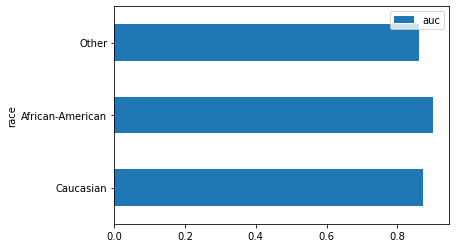

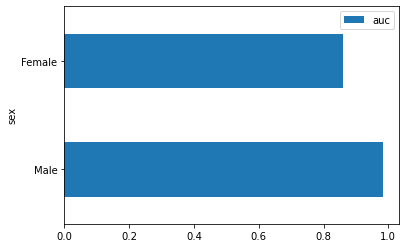

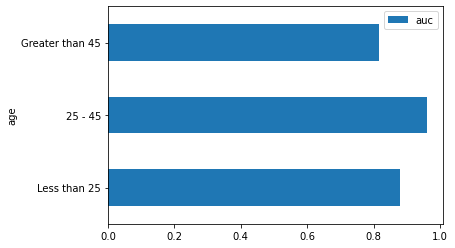

In [21]:
race_auc_df = pd.DataFrame({'race': races, 'auc': rm.by_group})
sex_auc_df = pd.DataFrame({'sex': sexes, 'auc': sm.by_group})
age_auc_df = pd.DataFrame({'age': age_groups, 'auc': am.by_group})
                     
display(race_auc_df[race_auc_df['auc'].notna()].plot.barh(x='race'))
display(sex_auc_df[sex_auc_df['auc'].notna()].plot.barh(x='sex'))
display(age_auc_df[age_auc_df['auc'].notna()].plot.barh(x='age'))

# Full model

In [32]:
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
import collections
from fairlearn.metrics import MetricFrame

TARGET_COL = 'target'

train_dataset = Pool(data=df_train[cols],
                     label=df_train[TARGET_COL],
                     cat_features=cat_cols)

eval_dataset = Pool(data=df_test[cols],
                    label=None,
                    cat_features=cat_cols)

# y_eval = pd.get_dummies(eval_df[TARGET_COL]).to_numpy()
# Initialize CatBoostClassifier
model = CatBoostClassifier(iterations=100,
                           learning_rate=1,
                           depth=2,
                           loss_function='MultiClass')
# Fit model
model.fit(train_dataset, verbose=True)
# Get predicted classes
preds_class = model.predict(eval_dataset)
#     # Get predicted probabilities for each class
preds_proba = model.predict_proba(eval_dataset)
#     # Get predicted RawFormulaVal
#     preds_raw = model.predict(eval_dataset, 
#                               prediction_type='RawFormulaVal')

feature_importances.append(model.get_feature_importance())

0:	learn: 0.3818517	total: 1.82ms	remaining: 181ms
1:	learn: 0.3021615	total: 4.04ms	remaining: 198ms
2:	learn: 0.2848920	total: 6.12ms	remaining: 198ms
3:	learn: 0.2806924	total: 8.43ms	remaining: 202ms
4:	learn: 0.2788880	total: 10.7ms	remaining: 204ms
5:	learn: 0.2732598	total: 13.5ms	remaining: 212ms
6:	learn: 0.2713431	total: 17.1ms	remaining: 228ms
7:	learn: 0.2678477	total: 19.8ms	remaining: 227ms
8:	learn: 0.2665858	total: 22.8ms	remaining: 231ms
9:	learn: 0.2636463	total: 25.7ms	remaining: 231ms
10:	learn: 0.2626877	total: 28ms	remaining: 227ms
11:	learn: 0.2613809	total: 30.5ms	remaining: 223ms
12:	learn: 0.2599854	total: 32.6ms	remaining: 218ms
13:	learn: 0.2569909	total: 34.6ms	remaining: 213ms
14:	learn: 0.2558415	total: 36.6ms	remaining: 207ms
15:	learn: 0.2552159	total: 38.9ms	remaining: 204ms
16:	learn: 0.2542071	total: 41ms	remaining: 200ms
17:	learn: 0.2534960	total: 43ms	remaining: 196ms
18:	learn: 0.2533199	total: 45.4ms	remaining: 194ms
19:	learn: 0.2523281	total: 

,feature,importance,std,min,max
4,days_until_recitivism,57.347517,6.349581,40.605683,67.970804
5,all_priors,14.699182,2.291297,9.575499,19.457343
3,in_custody_to_screening_days,9.170464,1.977178,5.396286,14.000008
2,custody_days,8.256618,1.721091,4.746703,13.223845
1,start,6.067779,1.812336,2.363908,9.608726
0,days_b_screening_arrest,4.458440,1.321198,2.385674,7.060029


<AxesSubplot:ylabel='feature'>

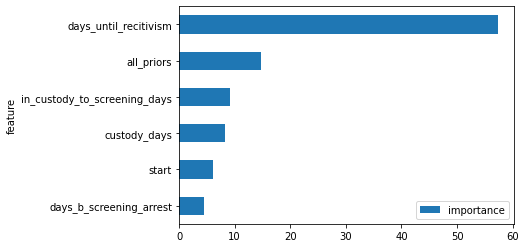

In [29]:
# Feature importances
fi_df = pd.DataFrame({'feature': cols})
fi_df['importance'] = np.mean(feature_importances, axis=0)
fi_df['std'] = np.std(feature_importances, axis=0)
fi_df['min'] = np.min(feature_importances, axis=0)
fi_df['max'] = np.max(feature_importances, axis=0)
fi_df = fi_df.sort_values('importance', ascending=False)
display(fi_df)
display(fi_df[['feature', 'importance']].sort_values('importance', ascending=True).plot.barh(x='feature'))

In [30]:
out_cols = ['No-Recidivism', 'Non-Violent', 'Violent']
out_df = pd.DataFrame(preds_proba, columns=out_cols)

# Make sure that classes are in the right order and the highest prediction corresponds to predicted class
out_df['class'] = out_df.apply(lambda x: out_cols[np.argmax(x[out_cols])], axis=1)
assert (out_df['class'] == preds_class.ravel()).all()
out_df = out_df[out_cols]

out_df.to_csv('y_test.csv', index=False)

import urllib.parse
upload_link = urllib.parse.quote('share.streamlit.io/mkleinbort/kaggle-compas/main/app.py')
y_test_link = urllib.parse.quote('y_test.csv')
print(f'Predictions were exported to "y_test.csv". Upload them at https://{upload_link}')
out_df

Predictions were exported to "y_test.csv". Upload them at https://share.streamlit.io/mkleinbort/kaggle-compas/main/app.py


,No-Recidivism,Non-Violent,Violent
0,0.976789,0.014207,0.009004
1,0.962154,0.023486,0.014360
2,0.000069,0.997825,0.002106
3,0.969112,0.017508,0.013380
4,0.969198,0.019414,0.011388
...,...,...,...
944,0.939616,0.046904,0.013480
945,0.926852,0.051257,0.021891
946,0.948634,0.027518,0.023848
947,0.000044,0.994195,0.005761


# Evaluations log
## 30/03/2021 22:18 JK
### Columns
['days_b_screening_arrest',
 'start',
 'custody_days',
 'in_custody_to_screening_days',
 'days_until_recitivism',
 'all_priors']
 
### Hyperparams
```
iterations=100,
learning_rate=1,
depth=2,
loss_function='MultiClass'
```

## Results
### CV
```
ROC-AUC 87.67% (STD: 1.96%)
Race fairness: 82.86% (STD: 4.02%)
Sex fairness: 84.82% (STD: 6.47%)
Age fairness: 81.86% (STD: 4.66%)
Score: 85.42%
```

### Online
```
{
  "accuracy": 0.8442265121761089,
  "fairness": 0.606948047720613
}
Overall Score: 72.56%
```